In [1]:
from pathlib import Path

project_path = Path().cwd().parent

en_pt_data_path = project_path / 'data/en-pt_BR.txt/'

data = {}
# open zip txt file
with open(en_pt_data_path / 'MDN_Web_Docs.en-pt_BR.en', 'rb') as f:
    data['en'] = f.read()
with open(en_pt_data_path / 'MDN_Web_Docs.en-pt_BR.pt_BR', 'rb') as f:
    data['br'] = f.read()

from rich import print

sample_size = 40 #100 #324 #956
sample_datas = {
    key: str(text[:sample_size]) for key, text in data.items()
}

complete_sentences = {
    key: str(text[:sample_size]).split('\\n')[1:] for key, text in data.items()
}
print(complete_sentences)

{'en': ["This article looks at '"], 'br': ["Este artigo analisa a '"]}

In [2]:
from magnitude.language_model_pre_trained import (
    PreTrainedLM,
    AutoModelForCausalLM,
    AutoTokenizer
)

checkpoint = "HuggingFaceTB/SmolLM2-135M-Instruct"
model_path = project_path.parent / f"models/{checkpoint}"
print(':: Reading model')

tokenizer = (AutoTokenizer
    .from_pretrained(model_path, local_files_only=True)
)
model = (AutoModelForCausalLM
    .from_pretrained(model_path, local_files_only=True)
)

print(f":: Memory footprint: {model.get_memory_footprint() / 1e6:.2f} MB")

ModuleNotFoundError: No module named 'magnitude'

In [3]:
self = PreTrainedLM(model, tokenizer, complete_sentences["en"])

In [4]:
ms = self.metric_space

[████████████████████████████████████████] 100.00% (10/10)


In [6]:
self.similarity_matrix

,This,This article,This article looks,This article looks at,This article looks at '
This,1.0,0.000067,4.569647e-07,3.924582e-07,2.755791e-10
This article,0.0,1.000000,6.840230e-03,5.874643e-03,4.125099e-06
This article looks,0.0,0.000000,1.000000e+00,8.588370e-01,6.030643e-04
This article looks at,0.0,0.000000,0.000000e+00,1.000000e+00,7.021871e-04
This article looks at ',0.0,0.000000,0.000000e+00,0.000000e+00,1.000000e+00


In [7]:
ms.get_magnitude()

4.133553768508136

/tmp/ipykernel_13157/2813177453.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  ms.plot_magnitude_curve(np.logspace(0, 1.5)).show()


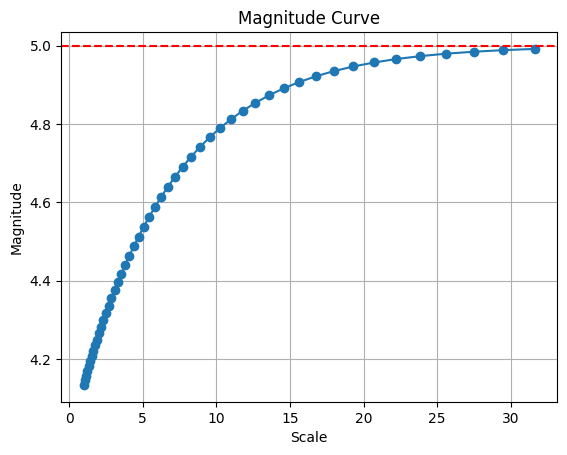

In [8]:
import numpy as np

ms.plot_magnitude_curve(np.logspace(0, 1.5)).show()

In [ ]:
x = 'It is raining,'
y = 'It is raining, therefore, I bring my umbrella'

z = ''

In [17]:
import torch
import torch.nn.functional as F

@torch.no_grad()
def next_token_logprobs(context: str):
    inputs = tokenizer(context, return_tensors="pt")

    outputs = model(**inputs)

    # logits do último token do contexto
    logits = outputs.logits[:, -1, :]      # (1, |V|)
    log_probs = F.log_softmax(logits, dim=-1)

    return log_probs.squeeze(0)             # (|V|,)

In [19]:
import torch
import torch.nn.functional as F
import math

@torch.no_grad()
def pi_y_given_x(model, tokenizer, x: str, y: str) -> float:
    # Caso x == y
    if x == y:
        return 1.0

    # Tokenização
    x_ids = tokenizer(x, add_special_tokens=False).input_ids
    y_ids = tokenizer(y, add_special_tokens=False).input_ids

    # Verifica se x é prefixo de y
    if y_ids[:len(x_ids)] != x_ids:
        return 0.0

    # Forward pass única com y inteiro
    inputs = torch.tensor([y_ids])
    outputs = model(input_ids=inputs)

    # Logits: (1, seq_len, vocab_size)
    logits = outputs.logits

    log_prob = 0.0

    # Índices correspondentes aos tokens novos
    for i in range(len(x_ids), len(y_ids)):
        token_id = y_ids[i]

        # logits que predizem y[i] vêm da posição i-1
        step_logits = logits[0, i-1]
        step_log_probs = F.log_softmax(step_logits, dim=-1)

        log_prob += step_log_probs[token_id].item()

    return math.exp(log_prob)

pi_y_given_x(model, tokenizer, x, y)



2.3405569700078035e-10